<a href="https://colab.research.google.com/github/carlosperez1997/flight_delay_prediction/blob/main/modelling_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling and Evaluation

In [2]:
!pip install lightgbm

In [3]:
# Basics
import pandas as pd
import numpy as np
import time
import os
from os import listdir
from os.path import isfile, join, basename
from tqdm import tqdm
from timeit import timeit
import gc

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pickle
import joblib

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgbm

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from matplotlib import rcParams

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#DIR = '/Users/carlosperezricardo/Desktop/TFM'
DIR = '/content/drive/MyDrive/TFM'

TARGET = 'ARR_DELAY'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
try: 
    df = pd.read_pickle(os.path.join(DIR,'df_preprocessed.pkl'))
except:
    df = pd.read_parquet(os.path.join(DIR,'df_preprocessed.parquet'))

df.shape

(1110432, 74)

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        try:
            if col_type != object:
                
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                #df[col] = df[col].astype('category')
                pass
        except:
            pass
            
    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
df = reduce_mem_usage(df)

df.isnull().sum()[df.isnull().sum()!=0]

Series([], dtype: int64)

In [9]:
def model_metrics(X_train, y_train, X_test, y_test, model):

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(' --- TRAIN --- ')
    print('     - RMSE: ', train_rmse)
    print('     - MAE: ', train_mae)
    print('     - R2: ', train_r2)
    print(' --- TEST --- ')
    print('     - RMSE: ', test_rmse)
    print('     - MAE: ', test_mae)
    print('     - R2: ', test_r2)

    return train_rmse, test_rmse, train_mae, test_mae, train_r2, train_r2

In [10]:
x = pd.DataFrame(df.dtypes).reset_index()
for k,r in x.iterrows():
    if r[0] == 'float64':
        print(r['index'])

## Train test split

In [11]:
features = list(df.select_dtypes(include=np.number).columns)
features.remove(TARGET)
features.remove('ARR_TIME')
features.remove('DIFF_DELAY')

X = df[features]
y = df[TARGET]

In [12]:
for col in X.columns:
    X[col] = X[col].astype('float32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (888345, 56)
Test: (222087, 56)


## Model selection

In [15]:
# Decision Tree
st = time.time()
dt = DecisionTreeRegressor(max_depth=10, criterion='squared_error')
dt.fit(X_train, y_train)

x = model_metrics(X_train, y_train, X_test, y_test, dt)
et = time.time()
print((et - st)/60)
pd.DataFrame({'columns': X_train.columns,'feature_importance':dt.feature_importances_}).sort_values('feature_importance',ascending=False).head(15)

 --- TRAIN --- 
     - RMSE:  11.263055372478787
     - MAE:  7.989970688784329
     - R2:  0.784766455807898
 --- TEST --- 
     - RMSE:  11.482965281577217
     - MAE:  8.094015876662834
     - R2:  0.7758904817941895
0.4173709829648336


,columns,feature_importance
8,DEP_DELAY,0.945657
55,DIFF_DELAY_ORIGIN_month_SCH_ARR_TIME_mean,0.032895
51,ARR_DELAY_ORIGIN_year_week_mean,0.014531
53,DIFF_DELAY_OP_CARRIER_AIRLINE_ID_month_SCH_ARR...,0.001166
32,Temperature_diff_low,0.000944
48,ARR_DELAY_OP_CARRIER_AIRLINE_ID_month_SCH_ARR_...,0.000600
50,ARR_DELAY_OP_CARRIER_AIRLINE_ID_year_week_mean,0.000409
49,ARR_DELAY_OP_CARRIER_AIRLINE_ID_month_UPD_ARR_...,0.000331
7,DEP_TIME,0.000292
54,DIFF_DELAY_ORIGIN_month_mean,0.000243


In [16]:
# Simplified Decision Tree
st = time.time()
dt = DecisionTreeRegressor(max_depth=3, criterion='squared_error')
dt.fit(X_train, y_train)

x = model_metrics(X_train, y_train, X_test, y_test, dt)
et = time.time()
print((et - st)/60)

 --- TRAIN --- 
     - RMSE:  12.662310270859548
     - MAE:  9.009371678534096
     - R2:  0.7279658538500472
 --- TEST --- 
     - RMSE:  12.66603488936163
     - MAE:  9.024027257638979
     - R2:  0.7273323856341598
0.1182668407758077


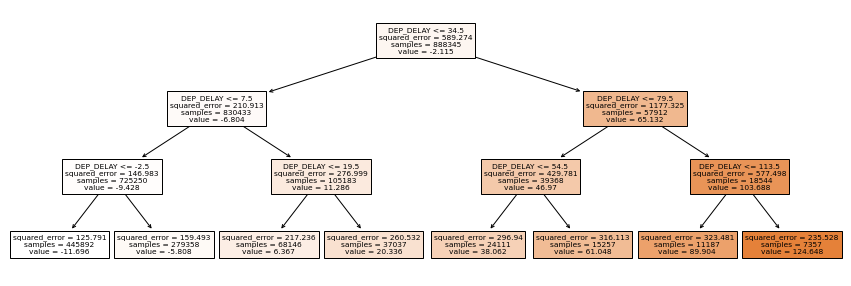

In [17]:
from sklearn import tree

fig = plt.figure(figsize=(15,5))
_ = tree.plot_tree(dt, 
                   feature_names=X_train.columns,  
                   class_names=X_train.dtypes,
                   filled=True)

plt.savefig(os.path.join(DIR,'images','dt_insights.png'))

In [18]:
# Random Forest (takes too long!)
if True:
    X_train_ = X_train.sample(200_000)
    y_train_ = y_train.loc[X_train_.index]

    st = time.time()
    rf = RandomForestRegressor(n_estimators = 70, max_depth=10, criterion='squared_error', random_state=42)
    rf.fit(X_train_, y_train_)

    x = model_metrics(X_train, y_train, X_test, y_test, rf)
    et = time.time()
    print((et - st)/60)

    pd.DataFrame({'columns': X_train.columns,'feature_importance':rf.feature_importances_}).sort_values('feature_importance',ascending=False).head(15)

 --- TRAIN --- 
     - RMSE:  11.192868440789418
     - MAE:  7.9250433937796885
     - R2:  0.7874405992665234
 --- TEST --- 
     - RMSE:  11.288852696453873
     - MAE:  7.980077861200044
     - R2:  0.7834033123791018
3.9450381954511005


In [19]:
# Gradient Boosting
if True:
    X_train_ = X_train.sample(150_000)
    y_train_ = y_train.loc[X_train_.index]

    st = time.time()
    gb = GradientBoostingRegressor(max_depth=10, criterion='squared_error', min_samples_leaf=30)
    gb.fit(X_train_, y_train_)

    x = model_metrics(X_train, y_train, X_test, y_test, gb)
    et = time.time()
    print((et - st)/60)

    pd.DataFrame({'columns': X_train.columns,'feature_importance':gb.feature_importances_}).sort_values('feature_importance',ascending=False).head(15)

 --- TRAIN --- 
     - RMSE:  10.372983987759145
     - MAE:  7.313340930792874
     - R2:  0.8174402914770504
 --- TEST --- 
     - RMSE:  10.610682791997469
     - MAE:  7.485157525331438
     - R2:  0.8086454200257625
5.993934690952301


In [20]:
# Lightgbm
st = time.time()
reg = lgbm.LGBMRegressor(n_estimators = 150, objective='rmse')
reg.fit(X_train, y_train)

x = model_metrics(X_train, y_train, X_test, y_test, reg)
et = time.time()
print((et - st)/60)

pd.DataFrame({'columns': X_train.columns,'feature_importance':reg.feature_importances_}).sort_values('feature_importance',ascending=False).head(15)

 --- TRAIN --- 
     - RMSE:  10.52546420782082
     - MAE:  7.438850393391218
     - R2:  0.8120336811734161
 --- TEST --- 
     - RMSE:  10.581314844958081
     - MAE:  7.470676705406017
     - R2:  0.8097032057063791
0.6490225752194723


,columns,feature_importance
8,DEP_DELAY,412
55,DIFF_DELAY_ORIGIN_month_SCH_ARR_TIME_mean,339
51,ARR_DELAY_ORIGIN_year_week_mean,271
42,airport_sum_ops,209
7,DEP_TIME,206
32,Temperature_diff_low,203
31,Temperature_diff_up,148
52,ARR_DELAY_year_week_mean,138
36,Humidity_low,136
53,DIFF_DELAY_OP_CARRIER_AIRLINE_ID_month_SCH_ARR...,128


### Hyperparameter tunning

In [21]:
if False: 
    st = time.time()
    mdl = lgbm.LGBMRegressor(silent = True)

    gridParams = {
        'n_estimators': [250,350,400,450],
        'num_leaves': [22,28,31], # large num_leaves helps improve accuracy but might lead to over-fitting
        'objective' : ['regression'],
        'metric' : ['rmse'],
        'random_state' : [42],
        }

    grid = GridSearchCV(mdl, gridParams, verbose=1, cv=5, n_jobs=-1)
    #grid = RandomizedSearchCV(mdl, gridParams, verbose=1, cv=3, n_jobs=-1, n_iter=20, random_state=42)
    # Run the grid
    grid.fit(X_train, y_train)

    # Print the best parameters found
    print(grid.best_params_)
    print(grid.best_score_)
    model = grid.best_estimator_

    et = time.time()
    print((et - st)/60)
else:
    st = time.time()
    model = lgbm.LGBMRegressor(n_estimators=400, num_leaves=31, objective='regression', random_state=42)
    model.fit(X_train, y_train)
    et = time.time()
    print((et - st)/60)

0.9610768000284831


In [22]:
x = model_metrics(X_train, y_train, X_test, y_test, model)

 --- TRAIN --- 
     - RMSE:  10.123259997399172
     - MAE:  7.195923338420655
     - R2:  0.8261245364685105
 --- TEST --- 
     - RMSE:  10.288528135977161
     - MAE:  7.279659568791333
     - R2:  0.8200885939837577


In [23]:
pd.DataFrame({'columns': X_train.columns,'feature_importance':model.feature_importances_}).sort_values('feature_importance',ascending=False).head(25)

,columns,feature_importance
7,DEP_TIME,938
8,DEP_DELAY,647
55,DIFF_DELAY_ORIGIN_month_SCH_ARR_TIME_mean,611
51,ARR_DELAY_ORIGIN_year_week_mean,582
16,lon_ORIGIN,519
15,lat_ORIGIN,459
42,airport_sum_ops,441
32,Temperature_diff_low,385
48,ARR_DELAY_OP_CARRIER_AIRLINE_ID_month_SCH_ARR_...,345
52,ARR_DELAY_year_week_mean,325


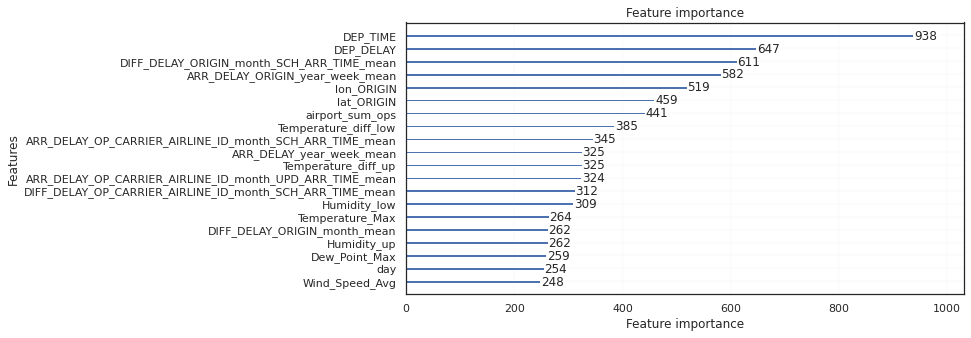

In [51]:
lgbm.plot_importance(model, max_num_features=20, importance_type='split', figsize=(10,5))
plt.savefig(os.path.join(DIR,'images','model_split_feature_importances.png'))

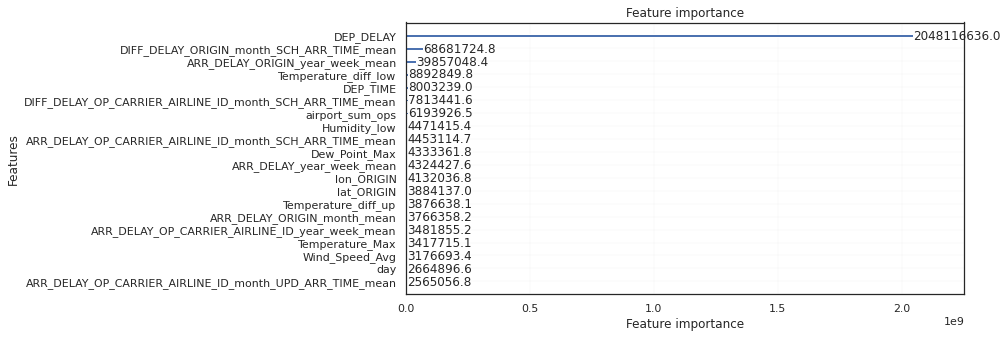

In [52]:
lgbm.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10,5), precision=1)
plt.savefig(os.path.join(DIR,'images','model_gain_feature_importances.png'))

In [24]:
def plotImp(model, X , num = 20, fig_size = (15, 10)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(style='white', rc={"grid.linewidth": 0.1}, font_scale = 1.3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num], palette = "Blues_r")
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(os.path.join(DIR,'images','model_feature_importances.png'))
    plt.show()

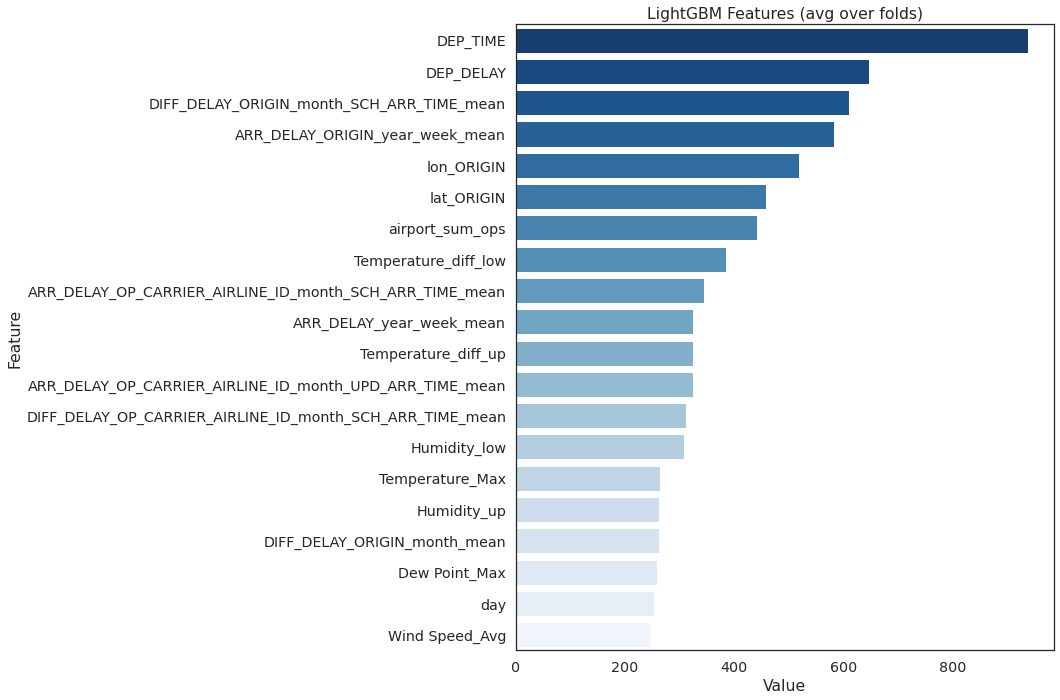

In [25]:
plotImp(model, X_train, num = 20)

In [ ]:
def plotgainImp(model, X , num = 20, fig_size = (15, 10)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(style='white', rc={"grid.linewidth": 0.1}, font_scale = 1.3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num], palette = "Blues_r")
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(os.path.join(DIR,'images','model_feature_importances.png'))
    plt.show()

## Evaluation

In [26]:
X_train_ = X_train.copy(deep=True)
X_train_['ARR_DELAY_pred'] = model.predict(X_train)
X_train_['ARR_DELAY'] = y_train
X_train_['ARR_DELAY_error'] = X_train_['ARR_DELAY'] - X_train_['ARR_DELAY_pred']

In [27]:
X_train_[['DEP_DELAY','ARR_DELAY','ARR_DELAY_pred','ARR_DELAY_error']].sort_values('ARR_DELAY', ascending=False).head(30)

,DEP_DELAY,ARR_DELAY,ARR_DELAY_pred,ARR_DELAY_error
index,,,,
230826,147.0,150.0,133.801227,16.198773
1857912,166.0,150.0,146.561511,3.438489
1690859,166.0,150.0,143.361675,6.638325
404738,165.0,150.0,134.494045,15.505955
1830914,158.0,150.0,143.060961,6.939039
1792271,167.0,150.0,140.796343,9.203657
382113,150.0,150.0,141.832165,8.167835
739441,158.0,150.0,146.153724,3.846276
1662035,152.0,150.0,138.287971,11.712029


In [28]:
X_train_[['DEP_DELAY','ARR_DELAY','ARR_DELAY_pred','ARR_DELAY_error']].sort_values('ARR_DELAY').head(20)

,DEP_DELAY,ARR_DELAY,ARR_DELAY_pred,ARR_DELAY_error
index,,,,
1476030,-5.0,-35.0,-14.881401,-20.118599
801860,-7.0,-35.0,-17.194513,-17.805487
215831,-5.0,-35.0,-14.599208,-20.400792
2207706,-4.0,-35.0,-22.764642,-12.235358
45649,-3.0,-35.0,-18.475852,-16.524148
1438873,-15.0,-35.0,-21.415592,-13.584408
1504157,-6.0,-35.0,-24.075415,-10.924585
679116,-5.0,-35.0,-9.184869,-25.815131
709090,0.0,-35.0,-10.826726,-24.173274


In [29]:
X_train_[['DEP_DELAY','ARR_DELAY','ARR_DELAY_pred','ARR_DELAY_error']].sort_values('ARR_DELAY_error', ascending=False).head(20)

,DEP_DELAY,ARR_DELAY,ARR_DELAY_pred,ARR_DELAY_error
index,,,,
53541,-7.0,138.0,3.693399,134.306601
432216,-2.0,125.0,-8.916298,133.916298
691520,-8.0,150.0,16.697662,133.302338
968558,7.0,137.0,4.016024,132.983976
1885460,12.0,145.0,12.234021,132.765979
54021,-5.0,121.0,-10.500933,131.500933
1833414,-9.0,129.0,-0.496074,129.496074
1952604,19.0,148.0,18.801106,129.198894
1077680,3.0,149.0,20.770615,128.229385


In [30]:
X_train_[['DEP_DELAY','ARR_DELAY','ARR_DELAY_pred','ARR_DELAY_error']].head(30)

,DEP_DELAY,ARR_DELAY,ARR_DELAY_pred,ARR_DELAY_error
index,,,,
717500,13.0,4.0,11.547463,-7.547463
1321114,-6.0,-11.0,-7.830244,-3.169756
1399828,-9.0,-29.0,-19.449966,-9.550034
773517,7.0,-10.0,-9.223448,-0.776552
1682906,-4.0,-5.0,-9.930721,4.930721
367532,-4.0,-15.0,-12.771913,-2.228087
1303941,-5.0,-13.0,-10.516023,-2.483977
184496,-1.0,2.0,-9.019109,11.019109
1190270,-4.0,2.0,-6.018616,8.018616


In [31]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
X_train_['ARR_DELAY_error'].describe(percentiles = perc).astype('float16')

count           inf
mean      -0.000000
std       10.125000
min     -127.562500
5%       -13.460938
10%      -10.640625
25%       -6.136719
50%       -1.125000
75%        4.578125
90%       11.351562
95%       16.921875
max      134.250000
Name: ARR_DELAY_error, dtype: float16

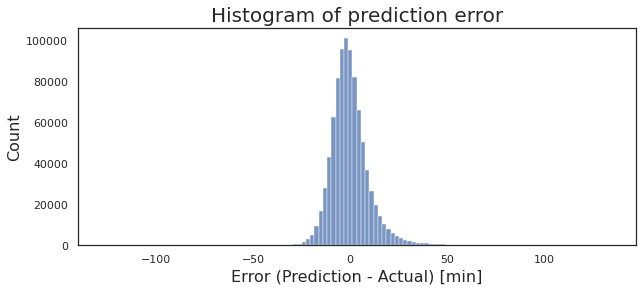

In [32]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

ax = sns.histplot(data=X_train_, x='ARR_DELAY_error', bins=120)
ax.axes.set_title("Histogram of prediction error",fontsize=20)
ax.set_xlabel("Error (Prediction - Actual) [min]",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.savefig(os.path.join(DIR,'images','ARR_DELAY_error_hist_train.png'))
plt.show()

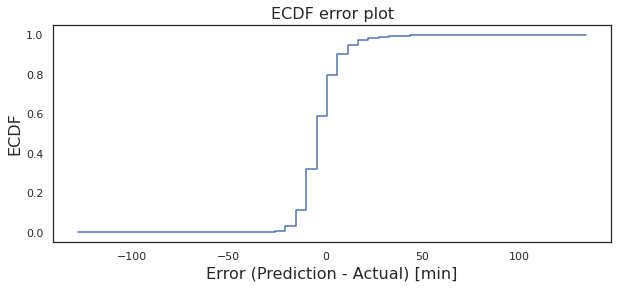

In [33]:
sample = X_train_['ARR_DELAY_error']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)

plt.figure(figsize=(10,4))
plt.step(x, y)
plt.title('ECDF error plot',fontsize=16)
plt.xlabel("Error (Prediction - Actual) [min]",fontsize=16)
plt.ylabel('ECDF',fontsize=16)
plt.savefig(os.path.join(DIR,'images','ARR_DELAY_error_ecdf_train.png'))
plt.show()

## Test

In [34]:
X_test_ = X_test.copy(deep=True)
X_test_['ARR_DELAY_pred'] = model.predict(X_test)
X_test_['ARR_DELAY'] = y_test
X_test_['ARR_DELAY_error'] = X_test_['ARR_DELAY'] - X_test_['ARR_DELAY_pred']

In [35]:
X_test_[['DEP_DELAY','ARR_DELAY','ARR_DELAY_pred','ARR_DELAY_error']].sort_values('ARR_DELAY', ascending=False).head(20)

,DEP_DELAY,ARR_DELAY,ARR_DELAY_pred,ARR_DELAY_error
index,,,,
1829920,152.0,150.0,136.547141,13.452859
1053182,136.0,150.0,128.835529,21.164471
748648,126.0,150.0,117.869003,32.130997
54460,-4.0,150.0,65.798252,84.201748
1705640,152.0,150.0,134.666071,15.333929
1250379,153.0,150.0,142.621793,7.378207
174669,163.0,150.0,143.996803,6.003197
538823,161.0,150.0,142.557220,7.442780
182887,112.0,150.0,122.095901,27.904099


In [36]:
X_test_[['DEP_DELAY','ARR_DELAY','ARR_DELAY_pred','ARR_DELAY_error']].sort_values('ARR_DELAY_error').head(20)

,DEP_DELAY,ARR_DELAY,ARR_DELAY_pred,ARR_DELAY_error
index,,,,
1092148,30.0,-15.0,37.383041,-52.383041
51610,-8.0,-34.0,15.221395,-49.221395
1143348,27.0,-7.0,41.706216,-48.706216
2066925,95.0,53.0,101.099154,-48.099154
832644,0.0,-7.0,40.575371,-47.575371
464481,30.0,-14.0,33.234326,-47.234326
1878272,42.0,-3.0,44.121596,-47.121596
1485307,-2.0,-9.0,37.367028,-46.367028
1141402,0.0,-14.0,30.096128,-44.096128


In [37]:
X_test_[['DEP_DELAY','ARR_DELAY','ARR_DELAY_pred','ARR_DELAY_error']].head(30)

,DEP_DELAY,ARR_DELAY,ARR_DELAY_pred,ARR_DELAY_error
index,,,,
567229,-5.0,-21.0,-15.667033,-5.332967
974871,2.0,6.0,-6.134559,12.134559
870851,-2.0,4.0,-0.232886,4.232886
532577,-6.0,1.0,-6.934401,7.934401
775145,-3.0,-2.0,-18.675743,16.675743
859179,-11.0,-23.0,-14.858643,-8.141357
338932,-14.0,-23.0,-10.727901,-12.272099
1252827,0.0,-10.0,-5.217157,-4.782843
1877068,16.0,5.0,12.899244,-7.899244


In [38]:
perc =[0.05, .10, .25, 0.5, 0.75, .90, 0.95]
X_test_['ARR_DELAY_error'].describe(percentiles = perc).astype('float16')

count           inf
mean      -0.010826
std       10.289062
min      -52.375000
5%       -13.640625
10%      -10.773438
25%       -6.214844
50%       -1.154297
75%        4.593750
90%       11.468750
95%       17.125000
max      156.750000
Name: ARR_DELAY_error, dtype: float16

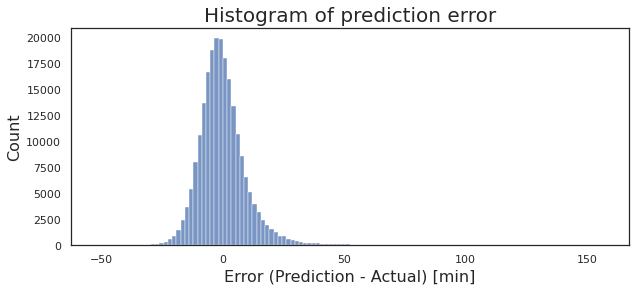

In [39]:
sns.set(style='white', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(10,4))

ax = sns.histplot(data=X_test_, x='ARR_DELAY_error', bins=120)
ax.axes.set_title("Histogram of prediction error",fontsize=20)
ax.set_xlabel("Error (Prediction - Actual) [min]",fontsize=16)
ax.set_ylabel("Count",fontsize=16)
plt.savefig(os.path.join(DIR,'images','ARR_DELAY_error_hist_test.png'))
plt.show()

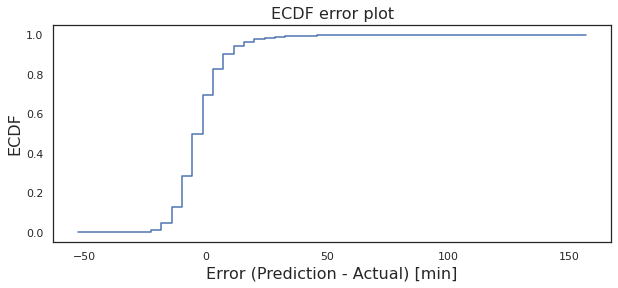

In [40]:
sample = X_test_['ARR_DELAY_error']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)

plt.figure(figsize=(10,4))
plt.step(x, y)
plt.title('ECDF error plot',fontsize=16)
plt.xlabel("Error (Prediction - Actual) [min]",fontsize=16)
plt.ylabel('ECDF',fontsize=16)
plt.savefig(os.path.join(DIR,'images','ARR_DELAY_error_ecdf_test.png'))
plt.show()